In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import ml_collections as mlc
import torch
from torch.autograd.functional import jacobian
import seaborn as sns

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

from Andreini_data.data import load_y

(879, 116)


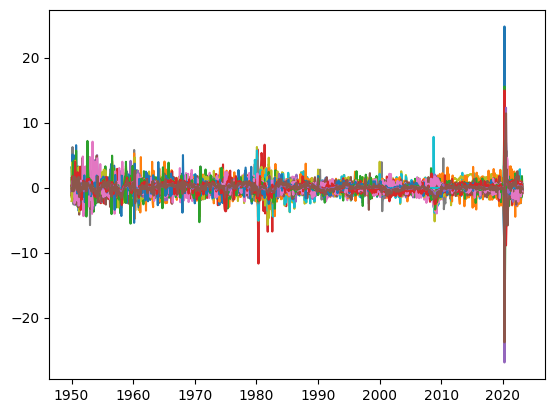

In [2]:

y, mask, index, columns= load_y(daterange=['1950-01-01', '2024-01-01'])
y[np.isnan(y)] = 0
print(y.shape)
plt.plot(index,y);

In [3]:
print(list(columns))
gdp_col = list(columns).index('GDPC1')

['PPIITM', 'PPICRM', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', 'IPMAN', 'MCUMFN', 'TCU', 'M0684AUSM343SNBR', 'M0504AUSM343SNBR', 'GDPC1', 'AMBSL', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'FEDFUNDS', 'CP3M', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM', 'TWEXMMTH', 'EXSZUS', 'EXJPUS', 'EXUSUK', 'EXCAUS', 'PPIFGS', 'PPIFCG', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'DPCERA3M086SBEA', 'CMRMTSPL', 'RETAIL', 'ACOGNO', 'ANDENO', 'AMDMUO', 'M1SL', 'M2SL', 'M3SL', 'M2REAL', 'RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'I

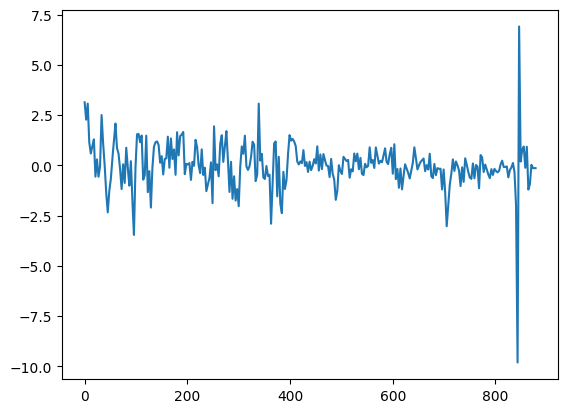

In [4]:
plt.plot(y[:,gdp_col])

(600, 116) (100, 116) (179, 116)


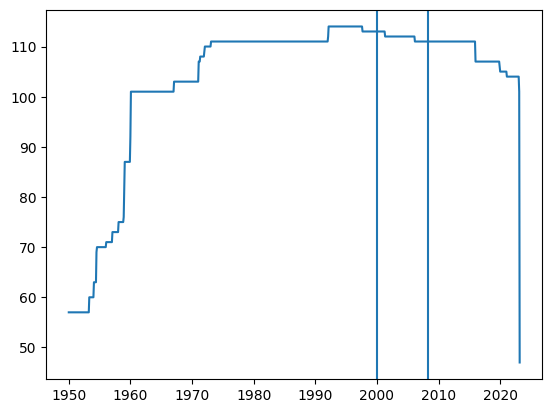

In [5]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 3
cfg.obs_dim = y.shape[1]
cfg.p_factor = 2
cfg.p_eps = 0
cfg.T_train = 600
cfg.T_test = 129
cfg.T_val = 100
cfg.T = y.shape[0] #529

#Training config
cfg.batch_size = 32
cfg.lr = 0.0001
cfg.n_epoch = 10
cfg.max_iter = 25


#Create train test val
y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]

weights_train = mask[0:cfg.T_train]
weights_val = mask[cfg.T_train:cfg.T_train+cfg.T_val]
print(y_train.shape, y_val.shape, y_test.shape)


plt.plot(index,mask.sum(axis=1))
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

Text(0, 0.5, 'N')

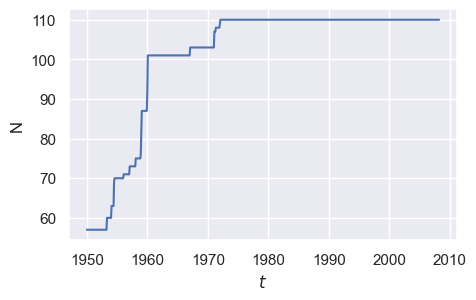

In [4]:
plt.figure(figsize=(5,3))
sns.set()
szs = mask.sum(axis=1)
szs = np.where(szs>110,110,szs)
plt.plot(index[:700],szs[:700])
plt.xlabel("$t$")
plt.ylabel('N')

In [6]:

cfg.lr = 0.003
cfg.max_iter = 30
cfg.n_epoch= 70
cfg.batch_size=512
cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Identity(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[cfg.obs_dim, 80,70,60,50,40, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=1)
metrics = []
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, weights_train=weights_train, weights_val=weights_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

/Users/julianvanmeggelen/Thesis/Empirical/../BasicAutoEncoder/model.py:60: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 24967
torch.Size([600, 116]) torch.Size([100, 116])
1 10.088930606842041606842041
2 0.43449607491493225491493225
3 0.43572385609149933609149933
4 0.34295232594013214594013214
5 0.32829292118549347118549347
6 0.30286651849746704849746704
7 0.26248729228973399228973394
8 0.25058585405349735405349734
9 0.23549704998731613998731613
10 0.2379398718476295584762955
11 0.2373173162341117923411179
12 0.2345088645815849358158493
13 0.2321440055966377359663773
14 0.2328056395053863550538635
15 0.2173299416899681168996818
16 0.2149364799261093192610931
17 0.2232777327299118272991186
18 0.2351351454854011548540115
19 0.2310077771544456515444565
20 0.2233443483710289837102892
21 0.2257342264056205740562057
22 0.2246183380484581804845819
23 0.2273292243480682434806824
24 0.2262686192989349429893494
25 0.2395248711109161411091614
26 0.2331547960639479606397037
27 0.2176447883248329232483292
28 0.2229584753513336235133362
29 0.2177890464663505646635056
30 0.22882181406021

In [10]:
from forecast import saveForecastError
saveForecastError(mod, "asymmetric.npy")

(179, 3)


array([[-2.4608620e-15,  5.2985446e-11, -1.0042869e-11, ...,
        -3.7897599e-01, -1.2714207e-01, -2.5155082e-01],
       [-2.7132329e-15,  3.0443939e-11, -2.2528479e-11, ...,
        -3.4099421e-01, -1.0857596e-01, -2.1352080e-01],
       [-2.6610633e-15,  3.2202914e-11, -3.9897807e-12, ...,
        -3.9428684e-01, -1.3224429e-01, -2.5177833e-01],
       ...,
       [-2.4214110e-15,  6.9772355e-11, -1.6138905e-10, ...,
        -2.4652742e-02,  2.2971375e-02, -2.6515357e-02],
       [-3.1656465e-15,  2.9486628e-11, -1.5435662e-10, ...,
         1.4089522e-01,  1.1091486e-01,  1.4484513e-01],
       [-3.2361167e-15,  1.9844744e-11, -1.9308199e-10, ...,
         2.0090720e-01,  1.3485399e-01,  1.8183252e-01]], dtype=float32)

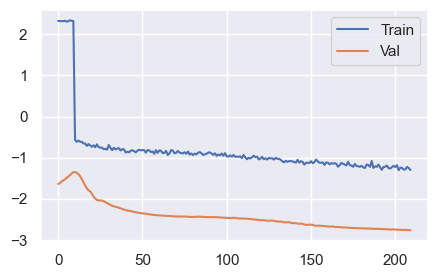

In [164]:
plot_train_hist(train_hist=train_hist, log=True)

Text(0, 0.5, 'Loss (logarithmic)')

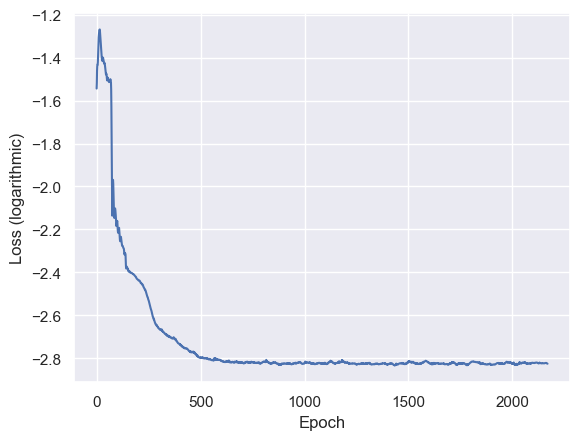

In [14]:
sns.set()
plt.plot(np.log(train_hist['val_loss']))
plt.xlabel('Epoch')
plt.ylabel('Loss (logarithmic)')

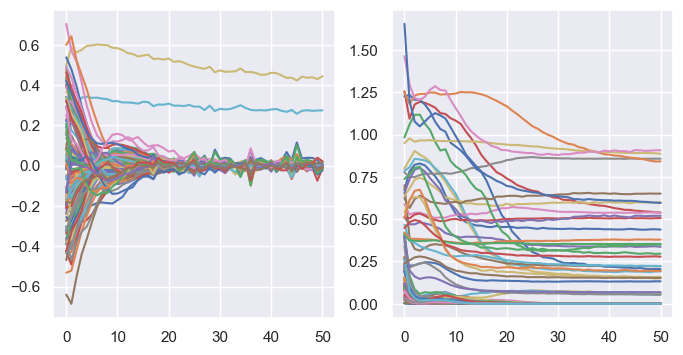

In [181]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(errorProcess.fit_hist['mu']);
ax2.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
ax1.set_title

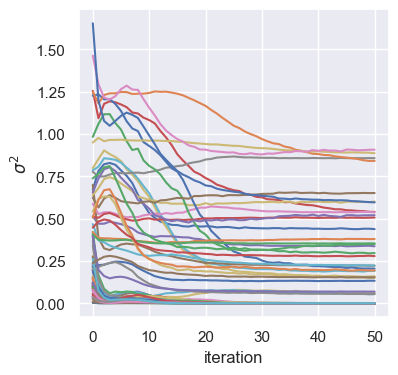

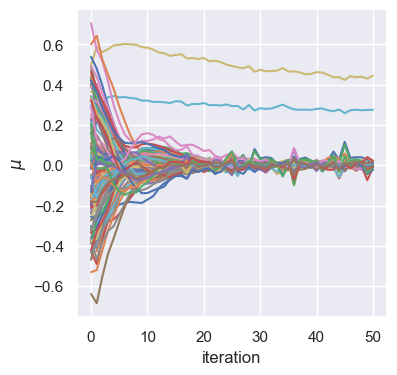

In [184]:
try:
    plt.figure(figsize=(4,4))
    plt.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
    plt.xlabel('iteration')
    plt.ylabel('$\sigma^2$')
    plt.figure(figsize=(4,4))
    plt.plot(errorProcess.fit_hist['mu']);
    plt.xlabel('iteration')
    plt.ylabel('$\mu$')
except:
    None
try:
    plt.plot(errorProcess.fit_hist['var']);
except:
    None


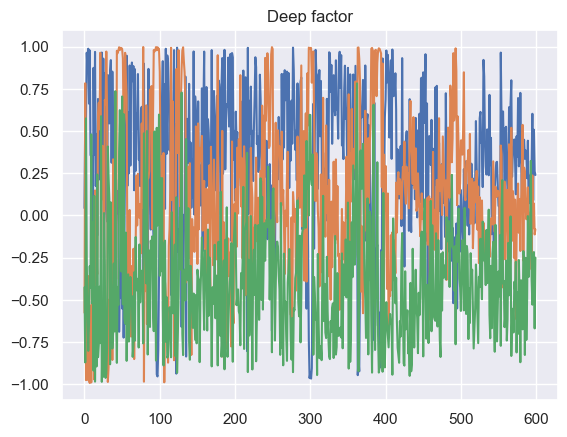

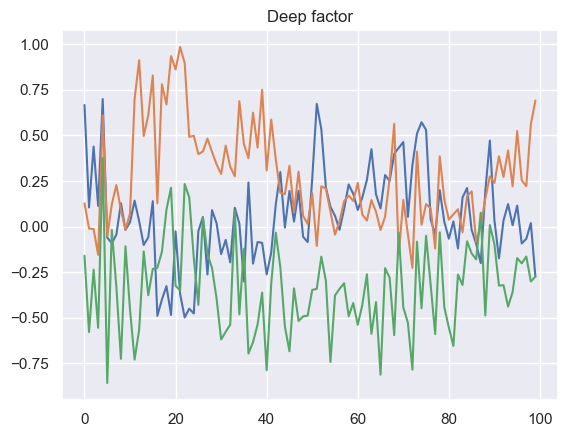

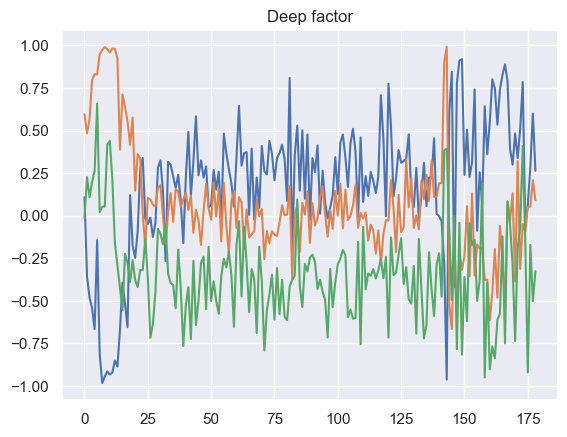

In [166]:
plot_factor_estimates(mod, y_train)
plt.figure();
plot_factor_estimates(mod, y_val)
plt.figure();
plot_factor_estimates(mod, y_test)

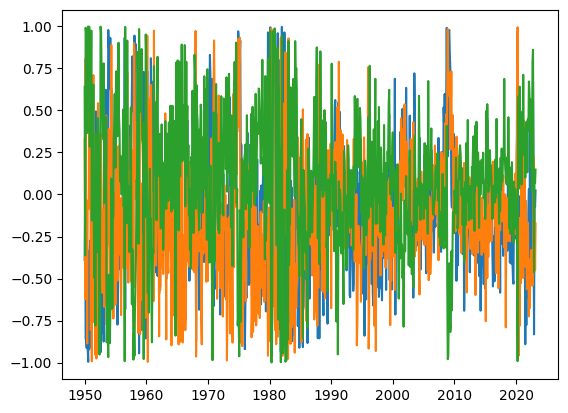

In [97]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
plt.plot(index, f_hat);

In [53]:
fn = fobreniusNorm(F)
np.sum(f_hat[0]*np.sum(F**2/fn,axis=0))


-0.04461767

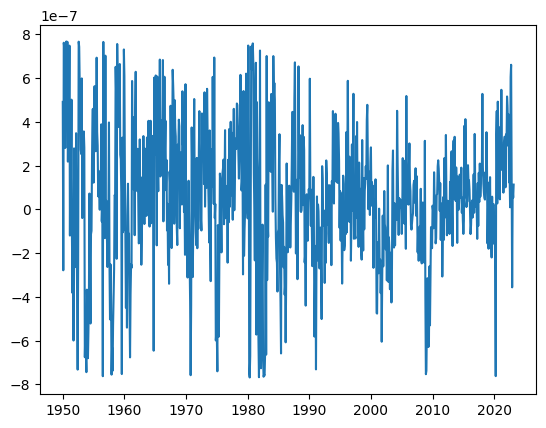

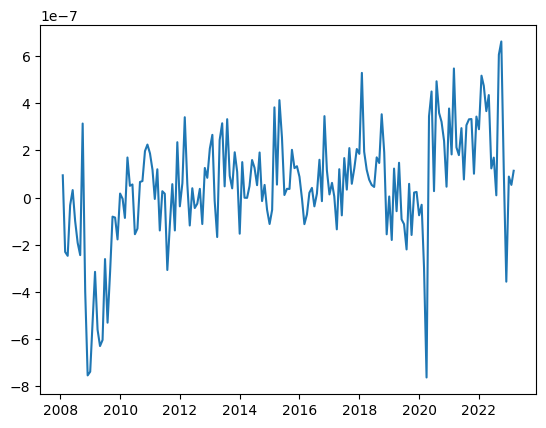

In [112]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCILinear(mod, f):
    F = mod.dec.sequential[0].weight.detach().numpy()
    fn = fobreniusNorm(F)
    res= []
    for t in range(f.shape[0]):
        sum = 0
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (F[k,i]**2)/fn
        res.append(sum)
    return np.array(res)
    return np.sum(f*np.sum(F**2/fn,axis=0),axis=1)
    return sum

def computeCI(mod, f):
    res= []
    for t in range(f.shape[0]):
        F = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy()
        fn = fobreniusNorm(F)       
        sum = 0
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (F[k,i]**2)/fn
        res.append(sum)
    return np.array(res)

F = mod.dec.sequential[0].weight.detach().numpy()
CI = computeCI(mod, f_hat)

plt.plot(index,CI)
plt.figure()
i = np.argwhere(index > '2008').min()
plt.plot(index[i:],CI[i:])

<Axes: >

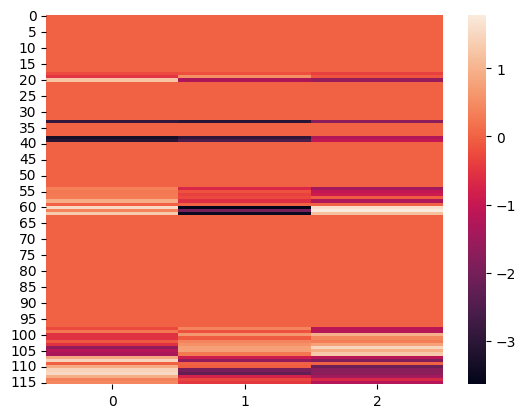

In [63]:
sns.heatmap(mod.dec.sequential[0].weight.detach().numpy())

torch.Size([116, 3])


<Axes: >

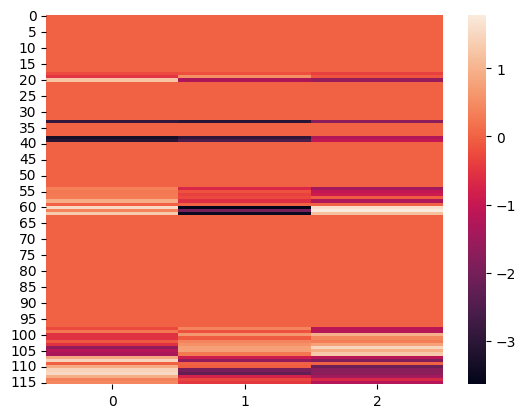

In [64]:
jac = jacobian(mod.dec, torch.tensor(f_hat[2]).float())
print(jac.shape)
sns.heatmap(jac)

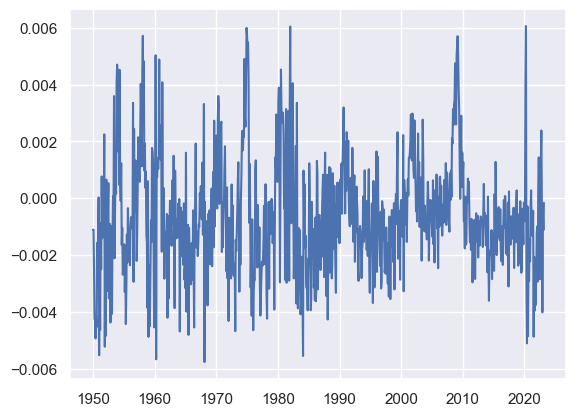

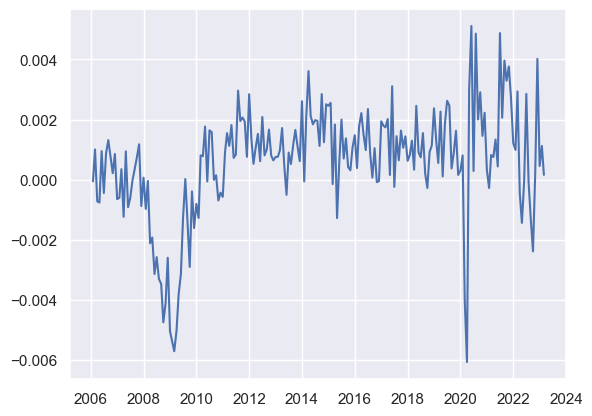

In [167]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(mod, f):
    res= []
    for t in range(f.shape[0]):
        F = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy()
        fn = fobreniusNorm(F)       
        sum = 0
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (F[k,i]**2)/fn
        res.append(sum)
    return np.array(res)

F = mod.dec.sequential[0].weight.detach().numpy()
CI = computeCI(mod, f_hat)

plt.plot(index,CI)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],CI[i:] * (-1 if flip else 1))


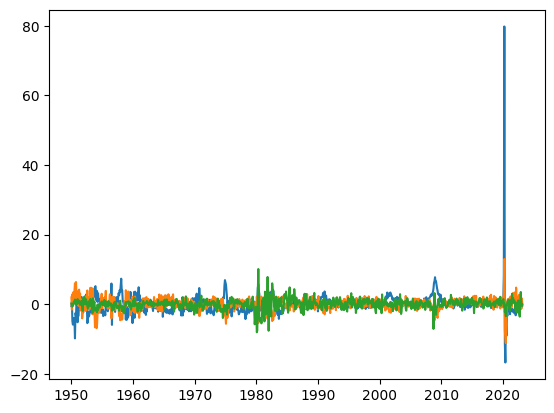

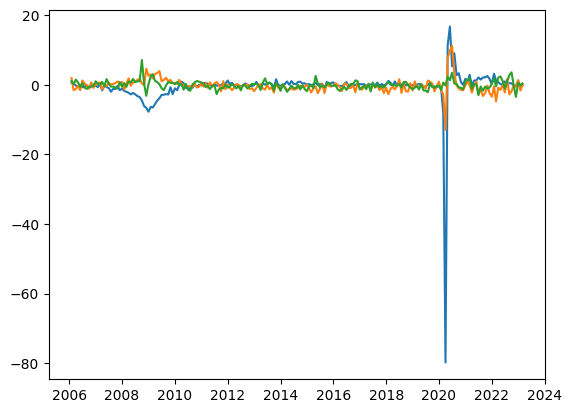

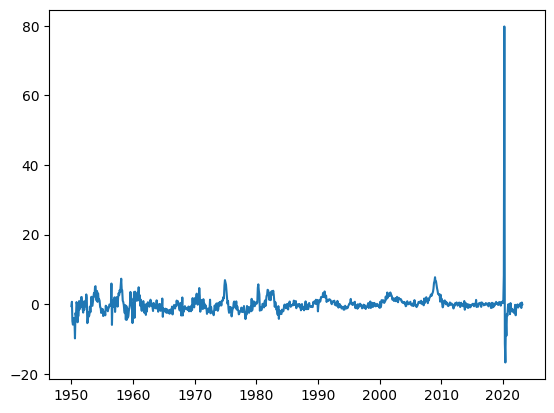

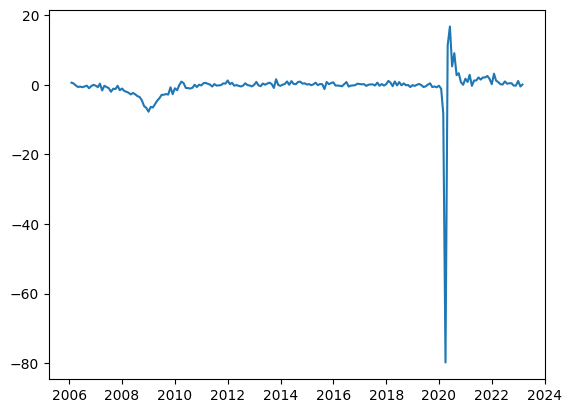

In [116]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))
plt.figure()
pca = PCA(n_components=1)
f_hat_pca = pca.fit_transform(y)
plt.plot(index,f_hat_pca)
plt.figure()
flip = True
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],f_hat_pca[i:] * (-1 if flip else 1))

## Cast in statespace with EKF

In [168]:
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
varModel = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = varModel.fit(maxlags=1, ic='aic')
y_hat = mod(torch.Tensor(y).float()).detach().numpy()
resid = y - y_hat
obs_cov = np.cov(resid.T)

In [85]:
np.cov((res.fittedvalues - np.concatenate([f_train_hat, f_val_hat])[1:]).T)

ValueError: operands could not be broadcast together with shapes (697,3) (699,3) 

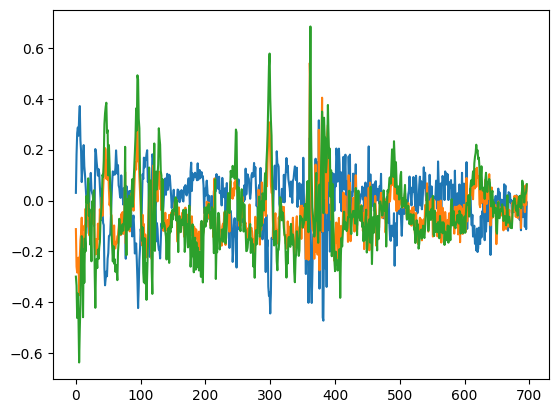

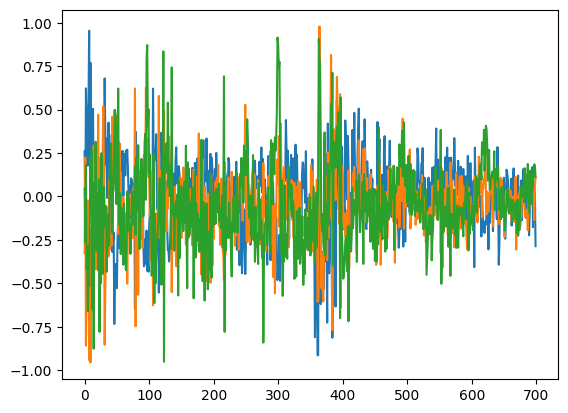

In [86]:
plt.plot(res.fittedvalues)
plt.figure()
plt.plot(np.concatenate([f_train_hat, f_val_hat]))

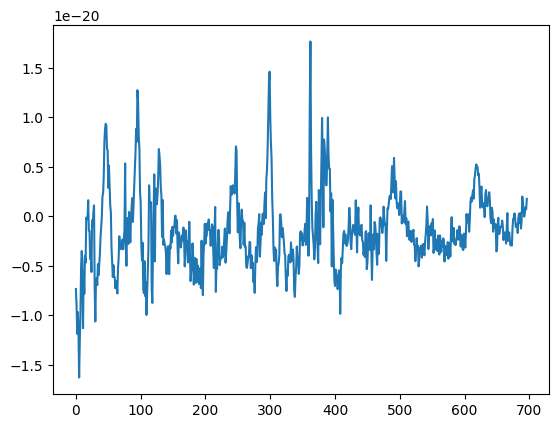

In [87]:
plt.plot(computeCI(mod,res.fittedvalues))

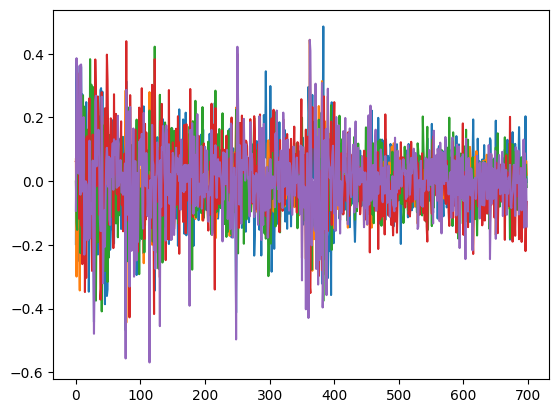

In [406]:
plt.plot(res.fittedvalues - np.concatenate([f_train_hat, f_val_hat])[1:])

<Axes: >

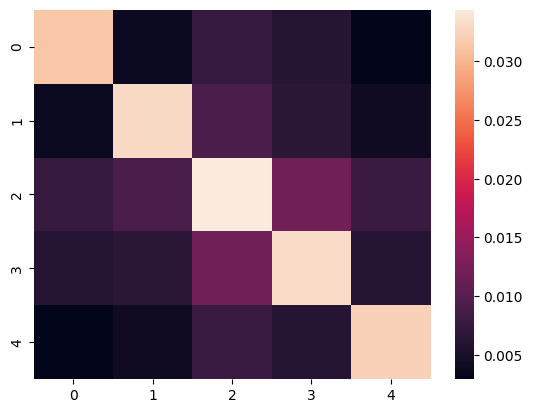

In [19]:
sns.heatmap(res.sigma_u)

<Axes: >

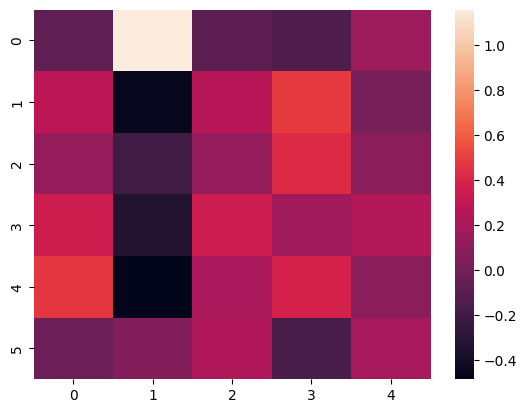

In [494]:
sns.heatmap(res.params[:])

In [88]:
res.params.T.round(3)

array([[-0.02 ,  0.322,  0.201,  0.01 , -0.023, -0.255, -0.216,  0.092,
         0.012, -0.058],
       [-0.024,  0.1  ,  0.247,  0.298, -0.175, -0.068, -0.002,  0.006,
         0.037, -0.001],
       [-0.015, -0.084,  0.261,  0.136, -0.117,  0.11 ,  0.304, -0.098,
        -0.081,  0.007]])

In [89]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Jun, 2023
Time:                     14:16:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.64151
Nobs:                     697.000    HQIC:                  -9.76155
Log likelihood:           491.268    FPE:                5.34264e-05
AIC:                     -9.83721    Det(Omega_mle):     5.11912e-05
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.020003         0.007973           -2.509           0.012
L1.y1         0.321684         0.038311            8.397           0.000
L1.y2         0.201433         0.040163            5.015           0.000
L1.y3         0.010371

<Axes: >

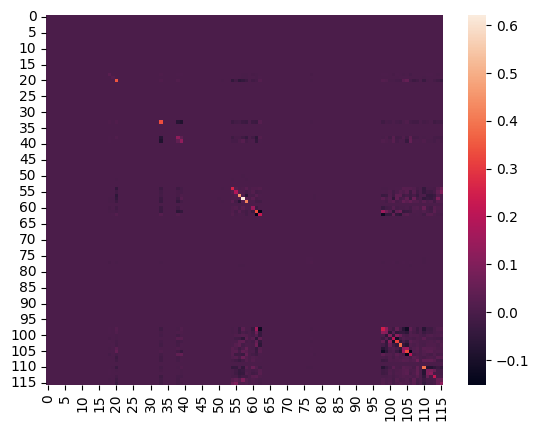

In [322]:
sns.heatmap(errorProcess.cov)

<Axes: >

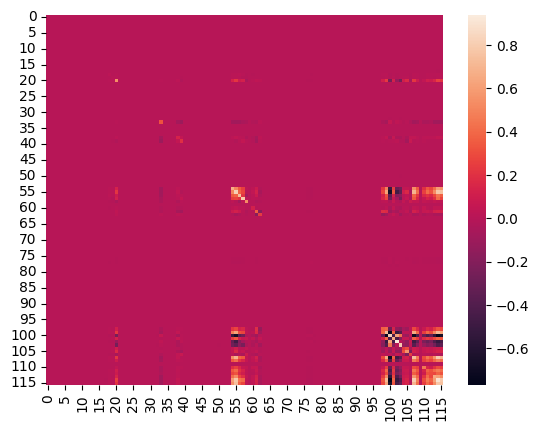

In [323]:
sns.heatmap(obs_cov)

In [146]:
from EKF.ekf import EKF, EKS, unconditionalVariance, unconditionalVariance2
y = y
Z = lambda x: mod.dec(torch.Tensor(x).float()).detach().numpy()
Z_jacobian = lambda x: jacobian(mod.dec, torch.Tensor(x).float()).detach().numpy()
H = errorProcess.cov
T = res.params[1:]
C = res.params[0]
R = np.identity(cfg.factor_dim)
Q = res.sigma_u
a0 = np.mean(f_train_hat, axis=0)
P0 = np.cov(f_train_hat.T) #None#res.sigma_u
a, P, a_filtered,Z_dot,v, K, F = EKF(y=y,Z=Z,Z_jacobian=Z_jacobian, H=H, T=T, R=R, Q=Q, C=None, a0=a0, P0=P0)


/Users/julianvanmeggelen/Thesis/Empirical/../EKF/ekf.py:86: RuntimeWarning: invalid value encountered in matmul
  a[t+1] = T @ a[t] + K[t] @ v[t] + C
/Users/julianvanmeggelen/Thesis/Empirical/../EKF/ekf.py:91: RuntimeWarning: invalid value encountered in matmul
  a_filtered[t] = a[t] + P[t] @ Z_dot[t].T @ Ft_inv @ v[t]
/Users/julianvanmeggelen/Thesis/Empirical/../EKF/ekf.py:89: RuntimeWarning: overflow encountered in matmul
  P[t+1] = T @ P[t] @ T.T + R @ Q @ R.T - K[t] @ F[t] @ K[t].T
/Users/julianvanmeggelen/Thesis/Empirical/../EKF/ekf.py:89: RuntimeWarning: invalid value encountered in matmul
  P[t+1] = T @ P[t] @ T.T + R @ Q @ R.T - K[t] @ F[t] @ K[t].T


KeyboardInterrupt: 

In [501]:
C

array([-0.07849305,  0.28075721,  0.1286408 ,  0.34743029,  0.46660979,
       -0.031834  ])

In [21]:
a_smoothed = EKS(Z_dot,F,v,a,P, T, K)

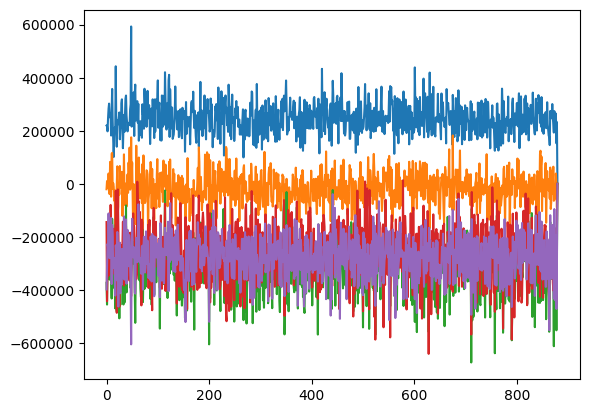

In [22]:
plt.plot(a_smoothed)

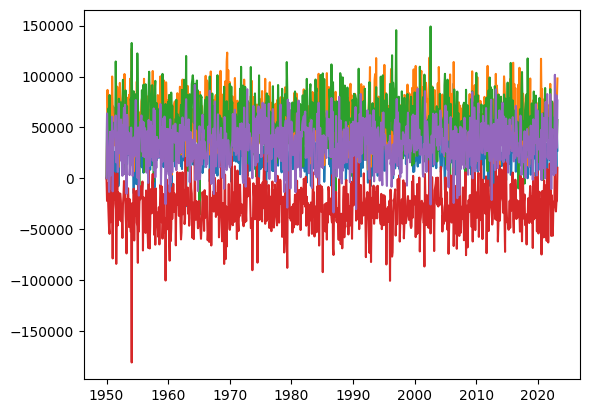

In [23]:
plt.plot(index,a[:])

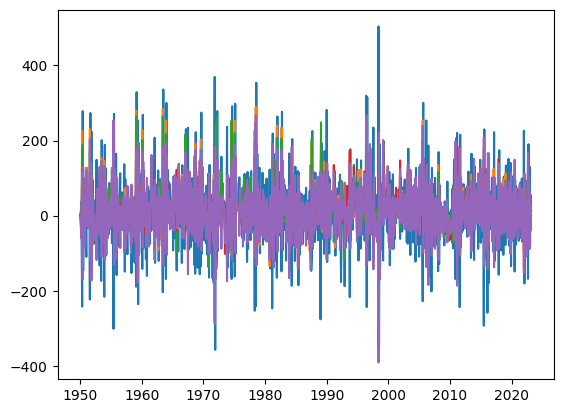

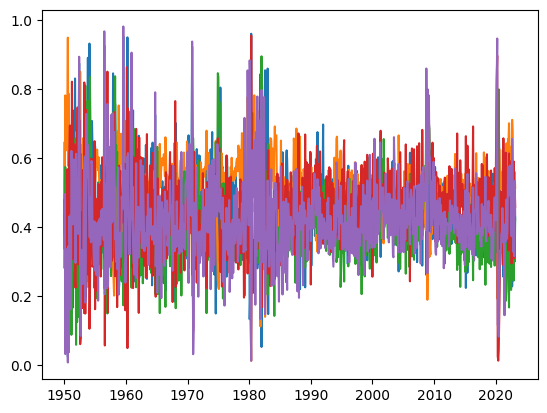

In [474]:
plt.plot(index,a)
plt.figure()
plt.plot(index,f_hat)

In [426]:
CI_filtered = computeCI(F, (a-a.max(axis=0)/(a.max(axis=0)-a.min(axis=0))))
plt.plot(CI_filtered)

/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar add
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn


/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar add
  sum += f[t,k] * (jac[k,i]**2)/fn
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_46634/1835430098.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sum += f[t,k] * (jac[k,i]**2)/fn


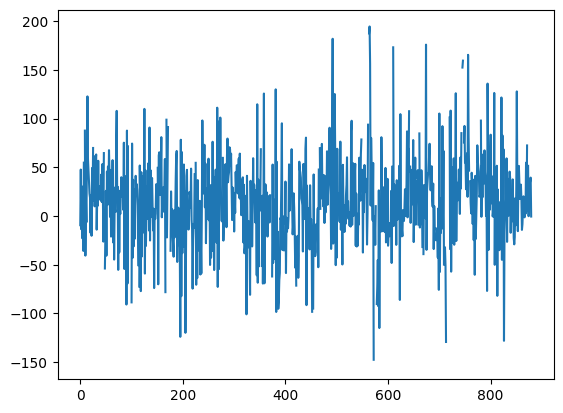

In [461]:
CI_filtered = computeCI(F, (a_smoothed-a_smoothed.max(axis=0)/(a_smoothed.max(axis=0)-a_smoothed.min(axis=0))))
plt.plot(CI_filtered)

In [190]:
res.sigma_u

array([[ 6.30185574,  4.17401048,  5.12210284,  4.03426597,  3.45850929],
       [ 4.17401048, 10.24410662,  6.82764073,  4.7609111 ,  5.24763828],
       [ 5.12210284,  6.82764073, 12.24474624,  6.3189485 ,  6.16086533],
       [ 4.03426597,  4.7609111 ,  6.3189485 , 15.63552312,  9.61933475],
       [ 3.45850929,  5.24763828,  6.16086533,  9.61933475, 14.55233607]])

In [196]:
res.mean()

array([5.87870346, 6.35967424, 6.35338814, 8.31293004, 8.66123531])

In [188]:
np.cov(f_train_hat.T).round(2)

array([[ 9.68,  7.64,  9.13, 11.03,  8.12],
       [ 7.64, 14.93, 11.67, 12.18, 10.34],
       [ 9.13, 11.67, 18.99, 15.24, 12.23],
       [11.03, 12.18, 15.24, 33.89, 21.28],
       [ 8.12, 10.34, 12.23, 21.28, 23.3 ]])

In [182]:
np.linalg.inv(np.identity(T.shape[0]**2)- np.kron(T,T)).shape

(25, 25)

In [226]:
print(unconditionalVariance(T,(res.sigma_u)).round(2))

[[-1091.19   144.89   -20.45    39.93   126.36]
 [  144.89    23.37     4.34    14.29    25.29]
 [  -20.45     4.34    12.95     4.63     2.84]
 [   39.93    14.29     4.63    21.9     21.34]
 [  126.36    25.29     2.84    21.34    43.24]]


In [154]:
res.sigma_u.shape

(5, 5)

In [152]:
res.params[-1]


array([-0.06869725, -0.06222471, -0.02176665, -0.14495933, -0.26186914])

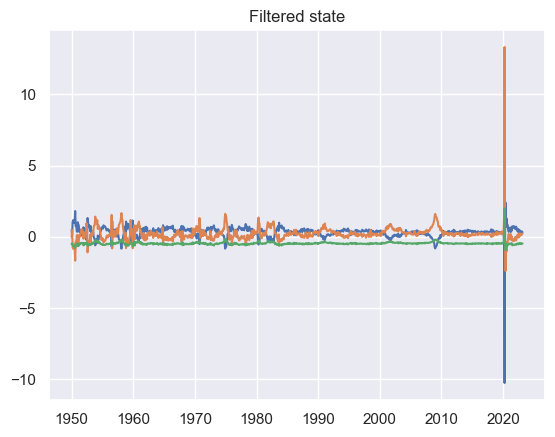

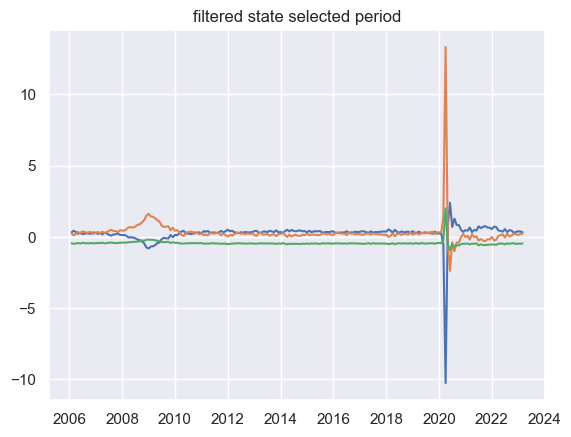

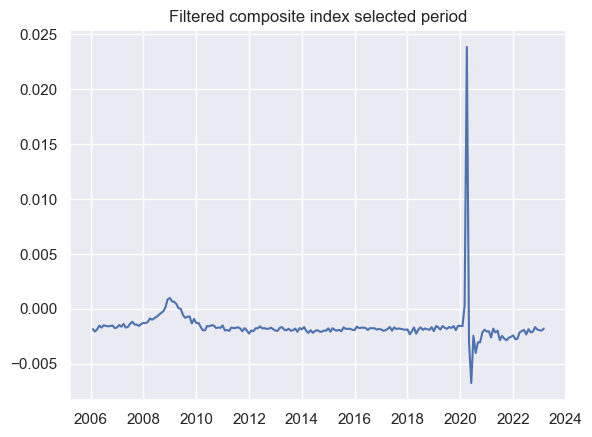

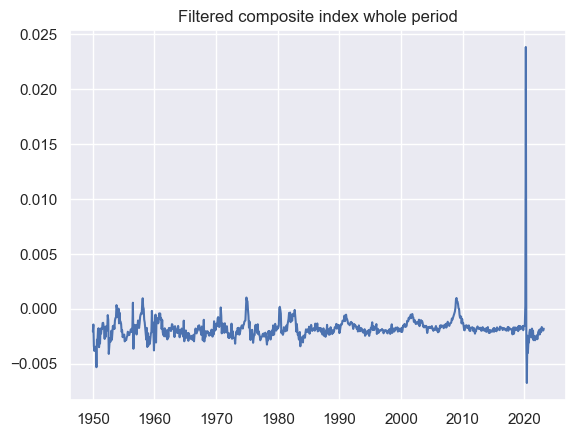

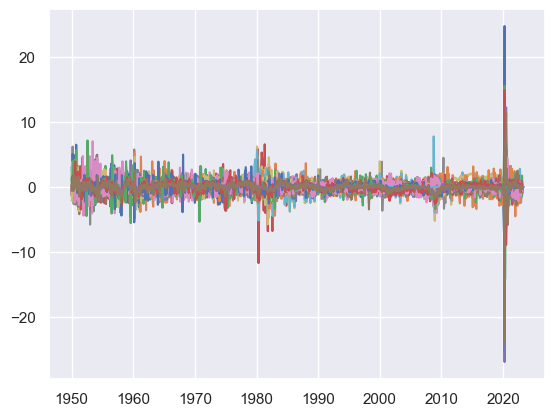

In [169]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
dim_x = cfg.factor_dim
dim_z = cfg.obs_dim
ekf = ExtendedKalmanFilter(dim_x, dim_z)
ekf.R = np.diag(np.diag(errorProcess.cov))
#ekf.R = errorProcess.cov
#ekf.R = obs_cov

ekf.Q = res.sigma_u
ekf.F = res.params[1:]
ekf.P = res.sigma_u
ekf.x = f_train_hat[0]
decoder = mod.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
y_kf = y#np.where(mask==1,y,np.nan)
for i in range(y.shape[0]):
    z = y_kf[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(index, np.stack(xs));
plt.title('Filtered state')
plt.figure()
i = np.argwhere((index > '2006') & (index < '2012')).min()
plt.plot(index[i:], np.stack(xs)[i:]);
plt.title('filtered state selected period')
plt.figure()
flip = True
CI_filtered = computeCILinear(mod, np.stack(xs))
plt.plot(index[i:],CI_filtered[i:] * (-1 if flip else 1))
plt.title('Filtered composite index selected period')
plt.figure()
plt.plot(index, CI_filtered * (-1 if flip else 1))
plt.title('Filtered composite index whole period')
plt.figure()
plt.plot(index, np.stack(zs));


Text(0.5, 1.0, 'Filtered composite index selected period')

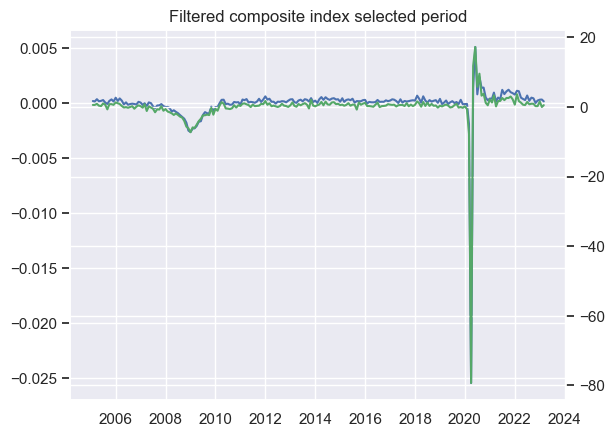

In [170]:
i = np.argwhere((index > '2005') & (index < '2012')).min()
ours = CI_filtered[i:]
ours= ours - ours.mean()
#ours = (ours-ours.max())/(ours.max()-ours.min())
pca  = f_hat_pca[i:]
#pca = (pca-pca.max())/(pca.max()-pca.min())
pca = pca-pca.mean()
plt.plot(index[i:],ours * (-1 if False else 1))

ax = plt.twinx()
ax.plot(index[i:],pca * (-1 if flip else 1), c='C2')
plt.title('Filtered composite index selected period')

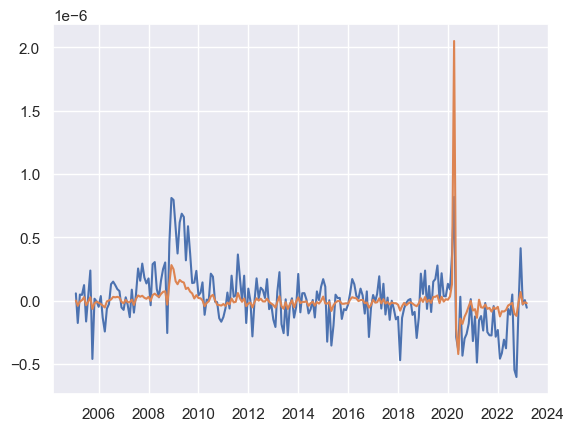

In [150]:
CI_demeaned = CI - CI.mean()
plt.plot(index[i:],CI_demeaned[i:] * (-1 if flip else 1))
plt.plot(index[i:],ours * (-1 if flip else 1))

In [31]:
err = np.stack(zs) - y
print(np.mean(err[cfg.T_train+cfg.T_val:]**2))

0.0


In [171]:
np.save(arr=CI_filtered, file='CI_filtered_assymetric_3')

In [172]:
np.save(arr=np.stack(xs), file='state_filtered_asymmetric_2')

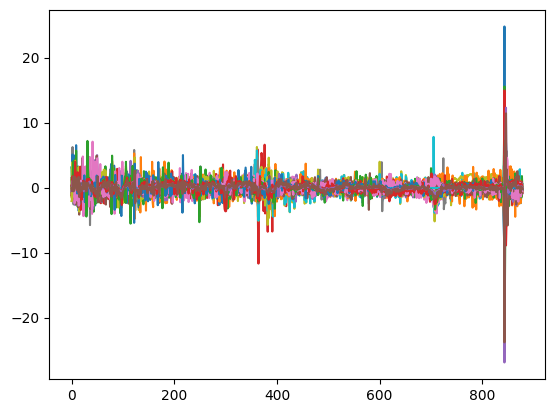

In [126]:
plt.plot(np.where(mask==1,y,None));

In [185]:
pred = mod(torch.from_numpy(y[cfg.T_train+cfg.T_val:]).float()).detach().numpy()
mse = (pred-y[cfg.T_train+cfg.T_val:])**2
np.save(arr=mse, file='mse_test_asymmetric')

In [186]:
print(np.mean(mse))

0.4599514431314659
